#### Import Required Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
import gradio as gr
import time

C:\Users\Acer\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define Gesture Labels

In [2]:
gesture_name_map = {
    '01_palm': 'Palm',
    '02_l': 'L-shape',
    '03_fist': 'Fist',
    '04_fist_moved': 'Fist Moved',
    '05_thumb': 'Thumb',
    '06_index': 'Index',
    '07_ok': 'OK',
    '08_palm_moved': 'Palm Moved',
    '09_c': 'C-shape',
    '10_down': 'Down'
}

def get_label_from_folder(folder_name):
    for key in gesture_name_map:
        if key in folder_name:
            return gesture_name_map[key]
    return None

#### Data Augmentation + HOG Feature Extraction

In [3]:
def augment_image(image):
    return [
        image,
        cv2.flip(image, 1),  # Horizontal flip
        cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    ]

def load_hog_features_augmented(dataset_path, img_size=128):
    X, y = [], []
    hog = cv2.HOGDescriptor()

    for user in sorted(os.listdir(dataset_path)):
        user_path = os.path.join(dataset_path, user)
        if not os.path.isdir(user_path): continue
        for gesture in os.listdir(user_path):
            label = get_label_from_folder(gesture)
            if label is None: continue

            gesture_path = os.path.join(user_path, gesture)
            for file in os.listdir(gesture_path):
                image_path = os.path.join(gesture_path, file)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if img is None: continue
                img = cv2.resize(img, (img_size, img_size))
                for aug in augment_image(img):
                    feat = hog.compute(aug).flatten()
                    X.append(feat)
                    y.append(label)
    return np.array(X), np.array(y)

#### Load Dataset & Preprocess

In [4]:
X, y = load_hog_features_augmented("leapGestRecog")
print("Loaded", len(X), "samples with", X.shape[1], "features.")
print("Unique gestures:", np.unique(y))

Loaded 60000 samples with 34020 features.
Unique gestures: ['C-shape' 'Down' 'Fist' 'Fist Moved' 'Index' 'L-shape' 'OK' 'Palm'
 'Palm Moved' 'Thumb']


#### Dimensionality Reduction with PCA

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#### Train Multiple Models

In [6]:
models = {
    "SVM": SVC(probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {"model": model, "y_pred": y_pred, "accuracy": acc}
    print(f" {name} Accuracy: {acc:.2f}")
    print(classification_report(y_test, y_pred))

 SVM Accuracy: 1.00
              precision    recall  f1-score   support

     C-shape       1.00      1.00      1.00      1200
        Down       1.00      1.00      1.00      1200
        Fist       1.00      1.00      1.00      1200
  Fist Moved       1.00      1.00      1.00      1200
       Index       1.00      1.00      1.00      1200
     L-shape       1.00      1.00      1.00      1200
          OK       1.00      1.00      1.00      1200
        Palm       1.00      1.00      1.00      1200
  Palm Moved       1.00      1.00      1.00      1200
       Thumb       1.00      1.00      1.00      1200

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

 RandomForest Accuracy: 1.00
              precision    recall  f1-score   support

     C-shape       1.00      1.00      1.00      1200
        Down       1.00      1.00      1.00      1200
        Fist       1.00      

#### Confusion Matrix & Comparison Plot

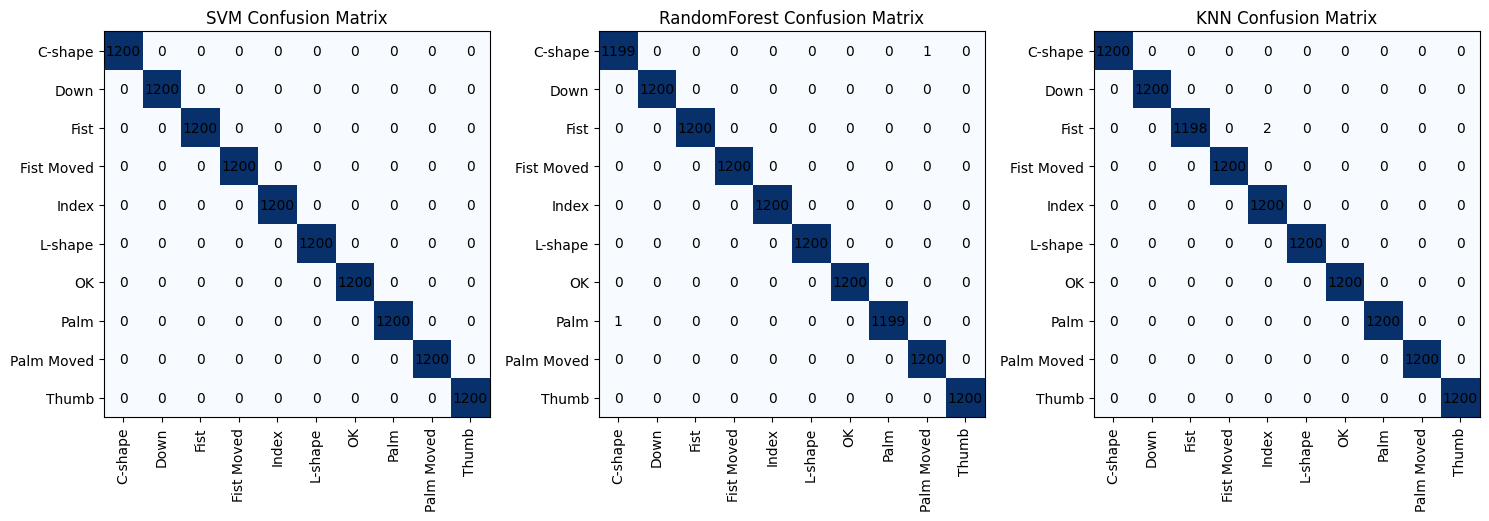

In [7]:
fig, axs = plt.subplots(1, len(results), figsize=(15, 5))
for i, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred'], labels=np.unique(y))
    axs[i].imshow(cm, cmap='Blues')
    axs[i].set_title(f"{name} Confusion Matrix")
    axs[i].set_xticks(range(len(np.unique(y))))
    axs[i].set_yticks(range(len(np.unique(y))))
    axs[i].set_xticklabels(np.unique(y), rotation=90)
    axs[i].set_yticklabels(np.unique(y))
    for (j, k), val in np.ndenumerate(cm):
        axs[i].text(k, j, str(val), ha='center', va='center')
plt.tight_layout()
plt.show()

#### ROC Curves

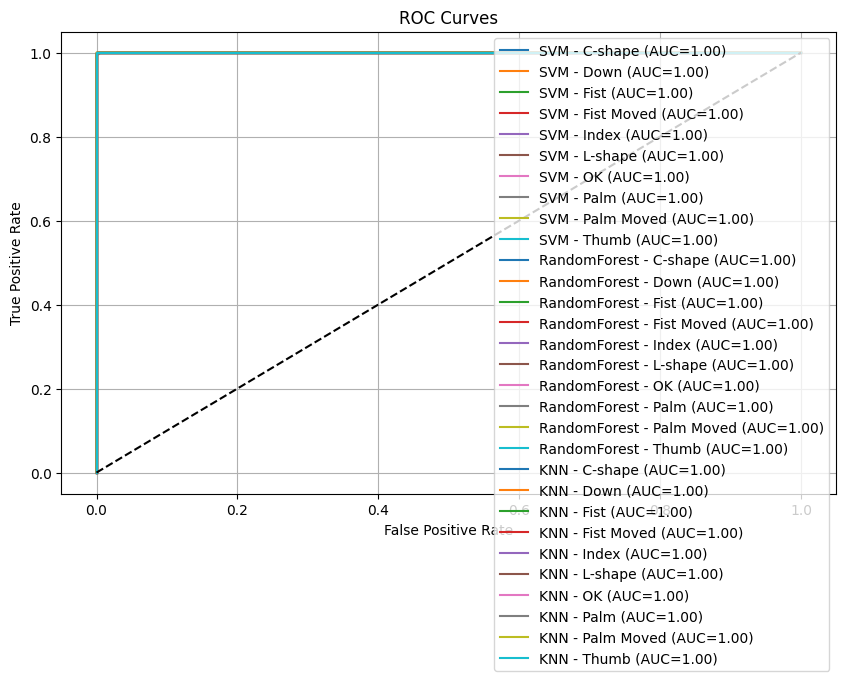

In [8]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
plt.figure(figsize=(10, 6))

for name, res in results.items():
    clf = OneVsRestClassifier(res["model"])
    clf.fit(X_train_pca, lb.fit_transform(y_train))
    y_score = clf.predict_proba(X_test_pca)
    for i in range(len(lb.classes_)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} - {lb.classes_[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()

#### Real-Time Prediction (Webcam)

In [9]:
def real_time_gesture_recognition(model, pca, img_size=128):
    cap = cv2.VideoCapture(0)
    hog = cv2.HOGDescriptor()
    prev_time = time.time()

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (img_size, img_size))
        feat = hog.compute(resized).flatten().reshape(1, -1)
        feat_pca = pca.transform(feat)
        pred = model.predict(feat_pca)[0]

        curr_time = time.time()
        fps = 1 / (curr_time - prev_time)
        prev_time = curr_time

        cv2.putText(frame, f"Gesture: {pred}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 65), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2)
        cv2.imshow("Real-Time Gesture Recognition", frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

#### Gradio Interface

In [10]:
def predict_gesture(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))
    feat = cv2.HOGDescriptor().compute(resized).flatten().reshape(1, -1)
    feat_pca = pca.transform(feat)
    pred = results["SVM"]["model"].predict(feat_pca)[0]
    return f"Predicted Gesture: {pred}"

gr.Interface(
    fn=predict_gesture,
    inputs=gr.Image(type="numpy", label="Upload Hand Gesture"),
    outputs="text",
    title="🖐 Hand Gesture Recognition",
    description="Upload an image of a hand gesture and get the predicted label."
).launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


#### To activate:

In [12]:
# real_time_gesture_recognition(results["SVM"]["model"], pca)